# testing without processor: edit features and cuts
Only `TTGamma` data, distinguishing prompt photons from fake photons

* `ak.flatten` instead of `ak.pad_none`
* Remove jet & muon features
* Remove 1 photon requirement. How to include `photon_count` feature?
* Add cut: pho-jet $\Delta R > 0.4$. ??? histograms look correct, but column accumulators have an issue

In [1]:
from coffea import hist, util

#import coffea.processor as processor
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
import awkward as ak
import numpy as np
import uproot

import matplotlib.pyplot as plt
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc

In [2]:
#Define files to run over
skimDir="/udrive/staff/dnoonan/Skims"

fileset = {"TTGamma":[f"{skimDir}/TTGamma_SingleLept_2016_skim.root"],
           "TTbar":[f"{skimDir}/TTbarPowheg_Semilept_2016_skim_1of10.root",
                    f"{skimDir}/TTbarPowheg_Semilept_2016_skim_2of10.root"],
          }

filesetData = {"DataMu":[f"{skimDir}/Data_SingleMu_b_2016_skim_1of10.root"],
              }

In [3]:
np.warnings.filterwarnings('ignore')

#the NanoAODSchema needs to be adjusted, to remove cross references to FSRPhotons
class SkimmedSchema(NanoAODSchema):
    def __init__(self, base_form):
        base_form["contents"].pop("Muon_fsrPhotonIdx", None)
        super().__init__(base_form)

In [4]:
# events from TTGamma
events = NanoEventsFactory.from_root(fileset["TTGamma"][0],
                                     schemaclass=SkimmedSchema,
                                     entry_stop=100000).events()

dataset = "TTGamma"

In [5]:
# photon cuts
photons = events.Photon
photonSelect= ((photons.pt>20) &
               (abs(photons.eta) < 1.4442) &
               (photons.isScEtaEE | photons.isScEtaEB) &
               (photons.electronVeto) & 
               np.invert(photons.pixelSeed)
               )
tightPhotons = photons[photonSelect]

In [6]:
# muon cuts
muons = events.Muon
muonSelectTight = ((muons.pt>30) &
                   (abs(muons.eta)<2.4) &
                   (muons.tightId) &
                   (muons.pfRelIso04_all < 0.15)
                  )
tightMuons = muons[muonSelectTight]

In [7]:
# jet & b-tagged jet cuts
jets = events.Jet

jetSelectTight = ((jets.pt>30) &
                  (abs(jets.eta)<2.4) &
                  (jets.isTight)
                 )
btaggedJetSelect = (jetSelectTight &
                   (jets.btagDeepB>0.6321)
                  )

tightJets = jets[jetSelectTight]
tightBJets = jets[btaggedJetSelect]

In [8]:
# electron cuts
electrons = events.Electron
electronSelectTight = ((electrons.pt> 35) &
                       (abs(electrons.eta)<2.1) &
                       (electrons.cutBased>=4)
                      )
tightEle = electrons[electronSelectTight]

In [9]:
## delta R using nearest
phoMu, phoMuDR   = tightPhotons.nearest(tightMuons,return_metric=True)
phoJet, phoJetDR = tightPhotons.nearest(tightJets,return_metric=True)

In [10]:
print('Pho:',tightPhotons)
print('Mu: ',tightMuons)
print('DR: ',phoMuDR)

# [] == no photon
# [None] == photon but no muon; will be removed by the event selection (ak.num(tightMuons)==1)

Pho: [[Photon], [], [], [Photon], [], [Photon, ... [], [], [Photon], [], [Photon], []]
Mu:  [[Muon], [], [], [Muon], [], [], [], [], ... [], [], [], [], [], [], [], [Muon]]
DR:  [[1.87], [], [], [2.99], [], [None, None, ... [], [], [None], [], [None], []]


In [11]:
# event cuts
trigger = events.HLT.IsoMu24 | events.HLT.IsoTkMu24

eventSelection = (trigger &
                  (ak.num(tightMuons)==1) &
                  (ak.num(tightJets)>=4) & 
                  (ak.num(tightBJets)>=1) &
                  (ak.num(tightEle)==0) &
                  (ak.num(tightPhotons)>=1) &
                  (phoJetDR>0.4))

In [12]:
phoJetDR>0.4

<Array [[True], [], [], ... [], [False], []] type='100000 * var * ?bool'>

In [13]:
##### histograms #####

In [14]:
dataset_axis = hist.Cat("dataset","Dataset")

photon_pt_axis = hist.Bin("pt","photon $p_{T}$ [GeV]", 40, 0, 400)
photon_eta_axis = hist.Bin("eta","photon $\eta$", 50, -2.5, 2.5)
photon_phi_axis = hist.Bin("phi","photon $\phi$", 64, -3.2, 3.2)
photon_reliso_all_axis = hist.Bin("reliso","photon pfRelIso03_all", 40, -0.5, 6)
photon_reliso_chg_axis = hist.Bin("reliso","photon pfRelIso03_chg", 40, -0.5, 6)
photon_sieie_axis = hist.Bin("sieie","photon sigma I eta I eta", 40, 0, 0.05)
photon_r9_axis = hist.Bin("r9","photon R9", 40, -0.5, 1.5)
photon_hoe_axis = hist.Bin("hoe","photon H over E", 40, -0.5, 1)
photon_count_axis = hist.Bin("count","Photon number",12,-1,10)

deltar_axis = hist.Bin("deltar","$\Delta R$", 50, -0.5, 4)

photon_genPartFlav_axis = hist.Bin("flav","genPartFlav",40,-1,15)

In [15]:
photon_pt_hist = hist.Hist("Counts", dataset_axis, photon_pt_axis)
photon_eta_hist = hist.Hist("Counts", dataset_axis, photon_eta_axis)
photon_phi_hist = hist.Hist("Counts", dataset_axis, photon_phi_axis)
photon_reliso_all_hist = hist.Hist("Counts", dataset_axis, photon_reliso_all_axis)
photon_reliso_chg_hist = hist.Hist("Counts", dataset_axis, photon_reliso_chg_axis)
photon_sieie_hist = hist.Hist("Counts", dataset_axis, photon_sieie_axis)
photon_r9_hist = hist.Hist("Counts", dataset_axis, photon_r9_axis)
photon_hoe_hist = hist.Hist("Counts", dataset_axis, photon_hoe_axis)
photon_count_hist = hist.Hist("Counts", dataset_axis, photon_count_axis)

deltaR_photon_lepton_hist = hist.Hist("Counts", dataset_axis, deltar_axis)
deltaR_photon_jet_hist = hist.Hist("Counts", dataset_axis, deltar_axis)

photon_genPartFlav_hist = hist.Hist("Counts", dataset_axis, photon_genPartFlav_axis)

In [16]:
photon_pt_hist.fill(dataset=dataset,
                    pt=ak.to_numpy(ak.flatten(tightPhotons[eventSelection].pt)))
photon_eta_hist.fill(dataset=dataset,
                     eta=ak.to_numpy(ak.flatten(tightPhotons[eventSelection].eta)))
photon_phi_hist.fill(dataset=dataset,
                     phi=ak.to_numpy(ak.flatten(tightPhotons[eventSelection].phi)))
photon_reliso_all_hist.fill(dataset=dataset,
                            reliso=ak.to_numpy(ak.flatten(tightPhotons[eventSelection].pfRelIso03_all)))
photon_reliso_chg_hist.fill(dataset=dataset,
                            reliso=ak.to_numpy(ak.flatten(tightPhotons[eventSelection].pfRelIso03_chg)))
photon_sieie_hist.fill(dataset=dataset,
                       sieie=ak.to_numpy(ak.flatten(tightPhotons[eventSelection].sieie)))
photon_r9_hist.fill(dataset=dataset,
                    r9=ak.to_numpy(ak.flatten(tightPhotons[eventSelection].r9)))
photon_hoe_hist.fill(dataset=dataset,
                     hoe=ak.to_numpy(ak.flatten(tightPhotons[eventSelection].hoe)))
photon_count_hist.fill(dataset=dataset,
                       count=(ak.num(tightPhotons[eventSelection])))

deltaR_photon_lepton_hist.fill(dataset=dataset,
                               deltar=ak.to_numpy(ak.flatten(phoMuDR[eventSelection])))
deltaR_photon_jet_hist.fill(dataset=dataset,
                            deltar=ak.to_numpy(ak.flatten(phoJetDR[eventSelection])))

photon_genPartFlav_hist.fill(dataset=dataset,
                             flav=ak.to_numpy(ak.flatten(tightPhotons[eventSelection].genPartFlav)))

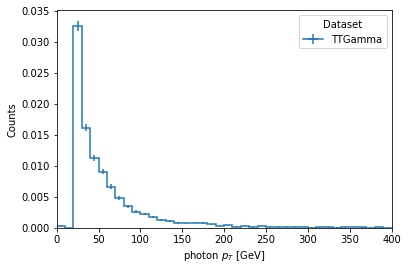

In [17]:
hist.plot1d(photon_pt_hist,overlay='dataset',stack=False,density=True)
plt.show()

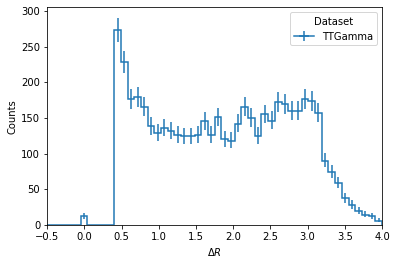

In [18]:
hist.plot1d(deltaR_photon_lepton_hist,overlay='dataset',stack=False)#,density=True)
plt.show()

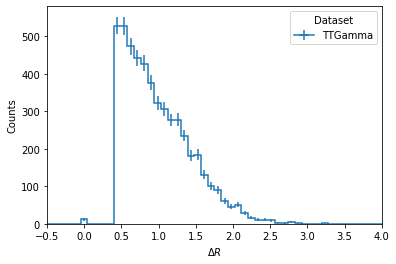

In [19]:
hist.plot1d(deltaR_photon_jet_hist,overlay='dataset',stack=False)#,density=True)
plt.show()

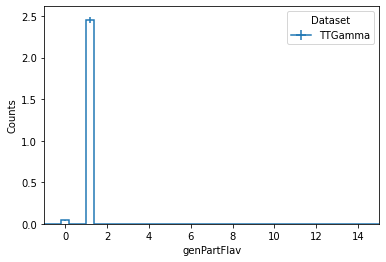

In [20]:
hist.plot1d(photon_genPartFlav_hist,overlay='dataset',stack=False,density=True)
plt.show()

In [21]:
###### column accumulators #######

In [22]:
photon_pt = ak.to_numpy(ak.flatten(tightPhotons.pt[eventSelection]))
photon_eta = ak.to_numpy(ak.flatten(tightPhotons.eta[eventSelection]))
photon_phi = ak.to_numpy(ak.flatten(tightPhotons.phi[eventSelection]))
photon_pfRelIso03_all = ak.to_numpy(ak.flatten(tightPhotons.pfRelIso03_all[eventSelection]))
photon_pfRelIso03_chg = ak.to_numpy(ak.flatten(tightPhotons.pfRelIso03_chg[eventSelection]))
photon_sieie = ak.to_numpy(ak.flatten(tightPhotons.sieie[eventSelection]))
photon_r9 = ak.to_numpy(ak.flatten(tightPhotons.r9[eventSelection]))
photon_hoe = ak.to_numpy(ak.flatten(tightPhotons.hoe[eventSelection]))

dim = ak.to_numpy(ak.num(tightPhotons[eventSelection]))
photon_count = ak.to_numpy(ak.num(tightPhotons[eventSelection]))

deltaR_photon_lepton = ak.to_numpy(ak.flatten(phoMuDR[eventSelection]))
deltaR_photon_jet = ak.to_numpy(ak.flatten(phoJetDR[eventSelection]))

photon_genPartFlav = ak.to_numpy(ak.flatten(tightPhotons.genPartFlav[eventSelection]))


In [23]:
photon_count.shape

(100000,)

In [24]:
dim = ak.to_numpy(ak.num(tightPhotons[eventSelection]))
print(dim) # number photons in each event
print(dim.shape) # number of events

[0 0 0 ... 0 0 0]
(100000,)


In [25]:
ak.to_numpy(ak.flatten(tightPhotons[eventSelection])).shape # number of photons

(5128,)

In [26]:
photon_pt.shape

(5128,)

In [27]:
np.array(photon_pt).shape

(5128,)

In [28]:
np.array(deltaR_photon_lepton).shape

(5128,)

In [29]:
####### processing for machine learning #######

In [30]:
df = pd.DataFrame({
    'photon_pt': np.array(photon_pt),
    'photon_eta': np.array(photon_eta),
    'photon_phi': np.array(photon_phi),
    'photon_hoe': np.array(photon_hoe),
    'photon_r9': np.array(photon_r9),
    'photon_sieie': np.array(photon_sieie),
    'photon_pfRelIso03_all': np.array(photon_pfRelIso03_all),
    'photon_pfRelIso03_chg': np.array(photon_pfRelIso03_chg),
    #'photon_count': np.array(photon_count), ### different shape than other features...
    'photon_genPartFlav': np.array(photon_genPartFlav),  ## target ##
    
    'deltaR_photon_lepton': np.array(deltaR_photon_lepton),
    'deltaR_photon_jet': np.array(deltaR_photon_jet),
})
df.describe()

,photon_pt,photon_eta,photon_phi,photon_hoe,photon_r9,photon_sieie,photon_pfRelIso03_all,photon_pfRelIso03_chg,photon_genPartFlav,deltaR_photon_lepton,deltaR_photon_jet
count,5128.000000,5128.000000,5128.000000,5128.000000,5128.000000,5128.000000,5128.000000,5128.000000,5128.000000,5128.000000,5128.000000
mean,59.812263,0.006113,-0.008686,0.007859,0.905628,0.009208,0.025339,0.008776,1.046412,1.875620,0.980995
std,56.296101,0.725257,1.826404,0.022198,0.125907,0.001089,0.123612,0.031897,2.916193,0.937635,0.444725
min,0.000000,-1.442139,-3.139648,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,26.275589,-0.566772,-1.590088,0.000000,0.918823,0.008850,0.000000,0.000000,1.000000,1.013071,0.618707
50%,40.977444,0.013137,-0.018076,0.000000,0.956055,0.009186,0.001183,0.000000,1.000000,1.893133,0.887818
75%,68.836470,0.569244,1.562317,0.004715,0.966309,0.009499,0.020783,0.003235,1.000000,2.684781,1.263214
max,550.472412,1.442871,3.141113,0.487305,1.092773,0.022308,5.257202,0.731495,177.000000,4.511411,3.276965


In [31]:
df.head()

,photon_pt,photon_eta,photon_phi,photon_hoe,photon_r9,photon_sieie,photon_pfRelIso03_all,photon_pfRelIso03_chg,photon_genPartFlav,deltaR_photon_lepton,deltaR_photon_jet
0,35.281075,1.013672,-2.959961,0.024109,0.959473,0.010345,0.018126,0.000000,1,0.673868,0.433896
1,49.449341,-0.927979,0.476990,0.000000,0.489990,0.009041,0.000000,0.000000,1,0.424922,0.429203
2,28.769894,-0.589233,-0.331116,0.000000,0.764160,0.008560,0.083477,0.083477,1,2.511429,0.605962
3,31.101566,0.875122,-0.901123,0.000000,0.967773,0.009857,0.000000,0.000000,1,1.692268,1.213066
4,152.660461,0.046585,-1.978027,0.005081,0.966797,0.008659,0.000000,0.000000,1,1.430684,0.719516


In [32]:
df['photon_genPartFlav'].value_counts()

1      5029
0        94
3         1
106       1
38        1
177       1
13        1
Name: photon_genPartFlav, dtype: int64

In [33]:
df = df[(df['photon_genPartFlav'] == 1) | (df['photon_genPartFlav'] == 0)]

In [34]:
df['photon_genPartFlav'].value_counts()

1    5029
0      94
Name: photon_genPartFlav, dtype: int64

In [35]:
# split into features and labels
X = np.array(df.drop(['photon_genPartFlav'],axis=1))
y = df['photon_genPartFlav']

# shuffle & split into training, validation, testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

print(X_train.shape)
print(y_train.max())
print(y_train.min())

(3073, 10)
1
0


In [36]:
# Scale: mean=0, stdev=1
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.fit_transform(X_val)
X_test_scaled = scaler.fit_transform(X_test)

In [37]:
model = Sequential()
model.add(Dense(32, input_shape=(X_train.shape[1],), activation="relu"))
model.add(Dense(32, activation="relu"))
model.add(Dense(1,activation="sigmoid"))

model.compile("adam", "binary_crossentropy", metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                352       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 1,441
Trainable params: 1,441
Non-trainable params: 0
_________________________________________________________________


In [38]:
model.fit(X_train_scaled, y_train, epochs=10, batch_size=128)

Epoch 1/10
25/25 [==============================] - 0s 1ms/step - loss: 0.5338 - accuracy: 0.8692
Epoch 2/10
25/25 [==============================] - 0s 1ms/step - loss: 0.3059 - accuracy: 0.9811
Epoch 3/10
25/25 [==============================] - 0s 1ms/step - loss: 0.1930 - accuracy: 0.9811
Epoch 4/10
25/25 [==============================] - 0s 1ms/step - loss: 0.1386 - accuracy: 0.9811
Epoch 5/10
25/25 [==============================] - 0s 1ms/step - loss: 0.1077 - accuracy: 0.9811
Epoch 6/10
25/25 [==============================] - 0s 1ms/step - loss: 0.0893 - accuracy: 0.9815
Epoch 7/10
25/25 [==============================] - 0s 1ms/step - loss: 0.0752 - accuracy: 0.9831
Epoch 8/10
25/25 [==============================] - 0s 1ms/step - loss: 0.0667 - accuracy: 0.9844
Epoch 9/10
25/25 [==============================] - 0s 1ms/step - loss: 0.0597 - accuracy: 0.9857
Epoch 10/10
25/25 [==============================] - 0s 1ms/step - loss: 0.0552 - accuracy: 0.9870


In [39]:
loss, accuracy = model.evaluate(X_test_scaled,y_test,verbose=0)
print(f'Test loss: {round(loss,5)}\nTest accuracy: {round(accuracy,5)}')

Test loss: 0.06745
Test accuracy: 0.98634


In [40]:
y_pred = model.predict(X_test_scaled)
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
area_under_curve = auc(fpr, tpr)

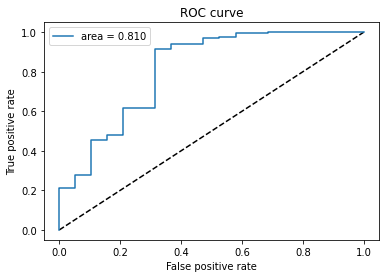

In [41]:
plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr, tpr, label='area = {:.3f}'.format(area_under_curve))

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [42]:
predTrue  = y_pred[y_test==True]
predFalse = y_pred[y_test==False]

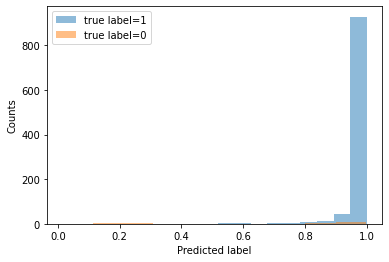

In [43]:
plt.hist(predTrue,alpha=0.5,label='true label=1')
plt.hist(predFalse,alpha=0.5,label='true label=0')

plt.xlabel('Predicted label')
plt.ylabel('Counts')
plt.title('')
plt.legend(loc='best')
plt.show()